In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
from scattering import *
from mesh import *

env: OMP_NUM_THREADS=1


In [2]:
c = 340
x0 = fd.Constant([0.5, 0])
h0 = 0.2

In [3]:
def exact_solution(mesh, k, x0):
    x = fd.SpatialCoordinate(mesh)
    z = k * fd.sqrt(fd.inner(x - x0, x - x0))
    u_re = -fd.bessel_Y(0, z) / 4
    u_im = fd.bessel_J(0, z) / 4
    return fd.as_vector([u_re, u_im])

def neumann_bc(mesh, k, x0):
    x = fd.SpatialCoordinate(mesh)
    n = fd.FacetNormal(mesh)
    z = k * fd.sqrt(fd.inner(x - x0, x - x0))
    dzdn = k / fd.sqrt(fd.inner(x - x0, x - x0)) * fd.dot(x - x0, n)
    dudn_re = fd.bessel_Y(1, z) / 4 * dzdn
    dudn_im = -fd.bessel_J(1, z) / 4 * dzdn
    return fd.as_vector([dudn_re, dudn_im])

# Sphere

In [4]:
shape = "sphere"
a0 = b0 = 2.0
a1 = b1 = 2.25
cached_mesh = True

if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0)

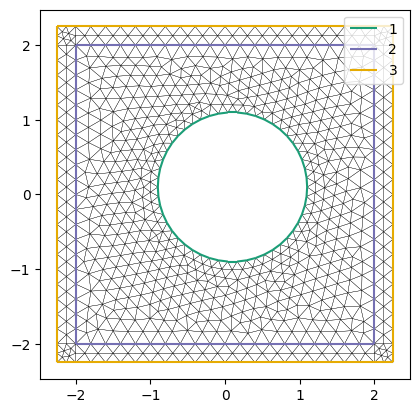

In [5]:
plot_mesh(mesh)

In [6]:
omega = 250
k = omega / c
u = exact_solution(mesh, k, x0)
uh = solve(mesh, k, a0, a1, b0, b1, u)

Exact solution:


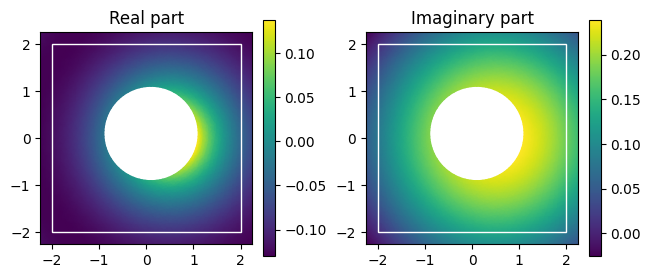

In [7]:
print("Exact solution:")
W = fd.VectorFunctionSpace(mesh, "CG", 1)
plot_field(fd.interpolate(u, W), a0, a1, b0, b1)

Numerical solution:


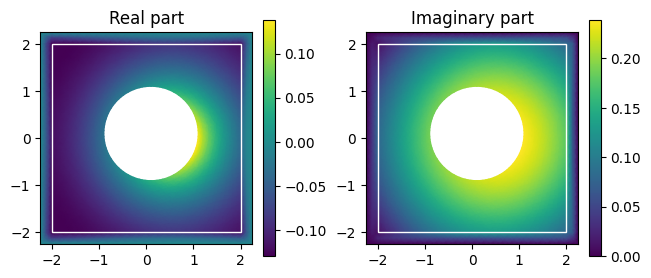

In [8]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

In [9]:
rel_err = compute_error(u, uh, quad_deg=4)
print(f"Relative error {rel_err:.2%}")

Relative error 1.26%


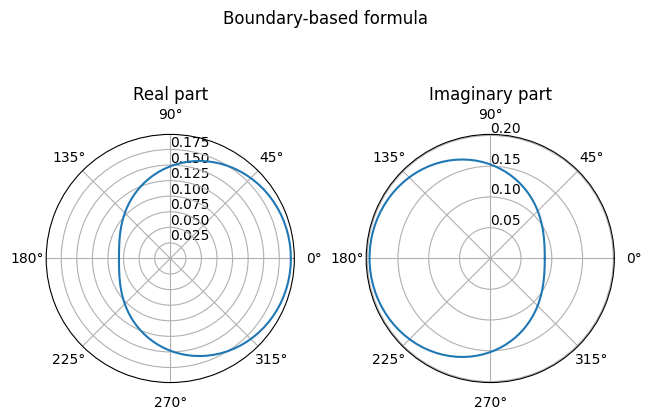

In [10]:
plot_far_field(k, uh)

In [11]:
# Convergence
max_level = 4
levels = np.arange(max_level)
hs = h0 / 2**levels
omegas = [250, 750, 1250, 1750]

In [12]:
# Uniform refinement
mesh_hierarchy = fd.MeshHierarchy(mesh, max_level)

angular freqency = 250
refinement level 0, relative error 1.26%
refinement level 1, relative error 0.28%
refinement level 2, relative error 0.08%
refinement level 3, relative error 0.02%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.01%
refinement level 1, relative error 0.64%
refinement level 2, relative error 0.18%
refinement level 3, relative error 0.06%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 4.13%
refinement level 1, relative error 1.09%
refinement level 2, relative error 0.30%
refinement level 3, relative error 0.08%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 8.85%
refinement level 1, relative error 2.36%
refinement level 2, relative error 0.61%
refinement level 3, relative error 0.16%
----------------------------------------


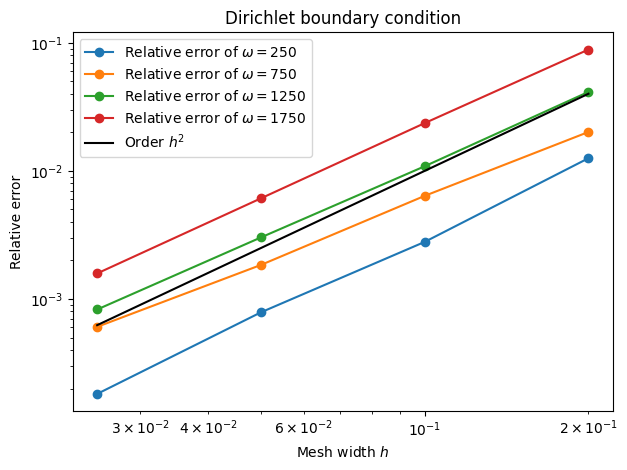

In [13]:
# Dirichlet problem
# L2 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.26%
refinement level 1, relative error 0.47%
refinement level 2, relative error 0.10%
refinement level 3, relative error 0.03%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.43%
refinement level 1, relative error 0.79%
refinement level 2, relative error 0.23%
refinement level 3, relative error 0.06%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.90%
refinement level 1, relative error 1.06%
refinement level 2, relative error 0.31%
refinement level 3, relative error 0.08%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 8.98%
refinement level 1, relative error 2.38%
refinement level 2, relative error 0.62%
refinement level 3, relative error 0.16%
----------------------------------------


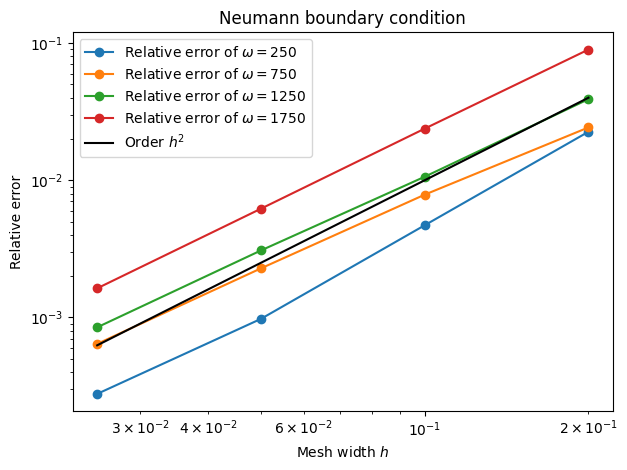

In [14]:
# Neumann problem
# L2 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

In [15]:
# Refinement by gmsh
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, h0, level))

angular freqency = 250
refinement level 0, relative error 1.26%
refinement level 1, relative error 0.88%
refinement level 2, relative error 0.49%
refinement level 3, relative error 0.18%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.01%
refinement level 1, relative error 0.87%
refinement level 2, relative error 0.48%
refinement level 3, relative error 0.35%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 4.13%
refinement level 1, relative error 1.23%
refinement level 2, relative error 0.46%
refinement level 3, relative error 0.21%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 8.85%
refinement level 1, relative error 2.55%
refinement level 2, relative error 0.71%
refinement level 3, relative error 0.22%
----------------------------------------


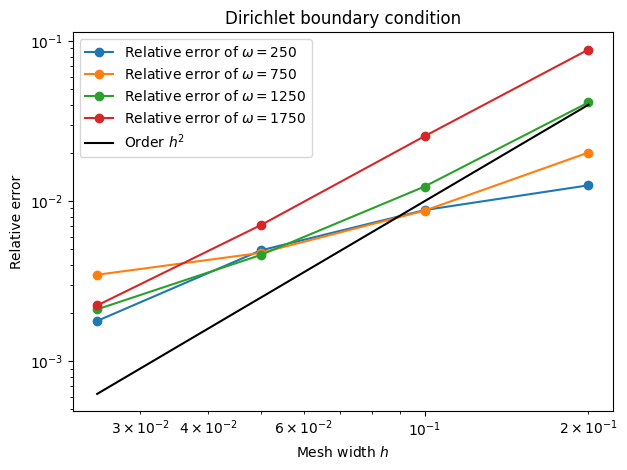

In [16]:
# Dirichlet problem
# L2 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.26%
refinement level 1, relative error 1.01%
refinement level 2, relative error 0.57%
refinement level 3, relative error 0.22%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.43%
refinement level 1, relative error 0.93%
refinement level 2, relative error 0.52%
refinement level 3, relative error 0.40%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.90%
refinement level 1, relative error 1.22%
refinement level 2, relative error 0.46%
refinement level 3, relative error 0.22%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 8.98%
refinement level 1, relative error 2.46%
refinement level 2, relative error 0.72%
refinement level 3, relative error 0.23%
----------------------------------------


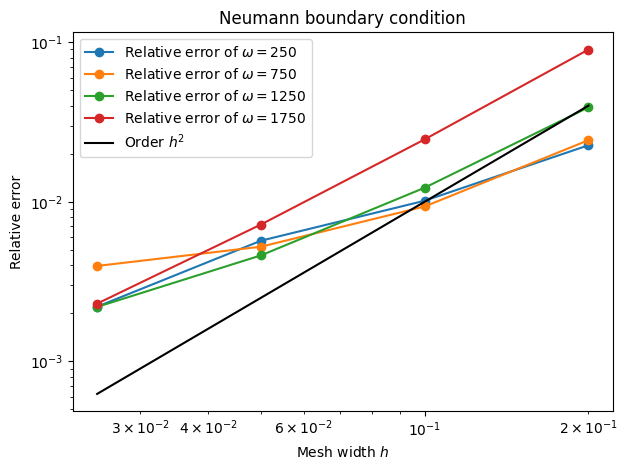

In [17]:
# Neumann problem
# L2 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 3.50%
refinement level 1, relative error 2.34%
refinement level 2, relative error 1.18%
refinement level 3, relative error 0.57%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 9.05%
refinement level 1, relative error 4.53%
refinement level 2, relative error 2.29%
refinement level 3, relative error 1.20%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 15.41%
refinement level 1, relative error 7.62%
refinement level 2, relative error 3.81%
refinement level 3, relative error 1.91%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 22.36%
refinement level 1, relative error 10.86%
refinement level 2, relative error 5.38%
refinement level 3, relative error 2.68%
----------------------------------------


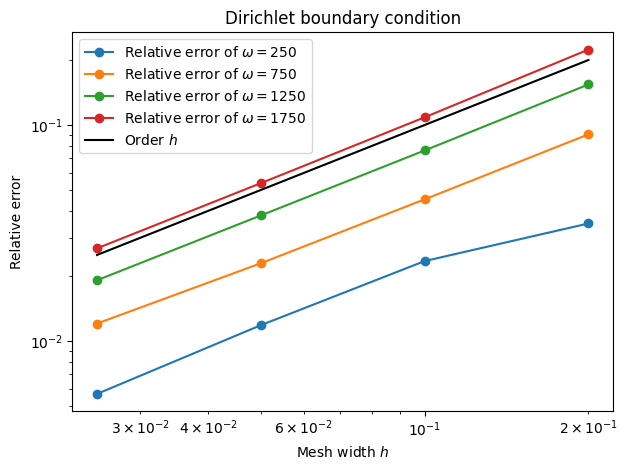

In [18]:
# Dirichlet problem
# H1 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 3.73%
refinement level 1, relative error 2.39%
refinement level 2, relative error 1.22%
refinement level 3, relative error 0.57%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 9.19%
refinement level 1, relative error 4.54%
refinement level 2, relative error 2.30%
refinement level 3, relative error 1.22%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 15.36%
refinement level 1, relative error 7.62%
refinement level 2, relative error 3.81%
refinement level 3, relative error 1.91%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 22.56%
refinement level 1, relative error 10.86%
refinement level 2, relative error 5.38%
refinement level 3, relative error 2.68%
----------------------------------------


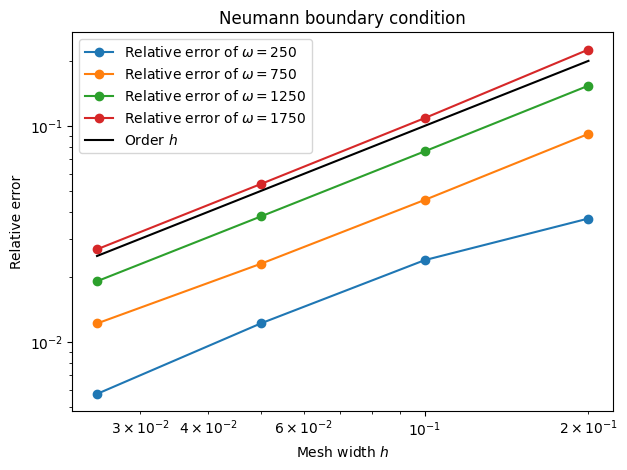

In [19]:
# Neumann problem
# H1 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

# Kite

In [20]:
shape = "kite"
a0 = b0 = 2.0
a1 = b1 = 2.25
cached_mesh = True

if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0)

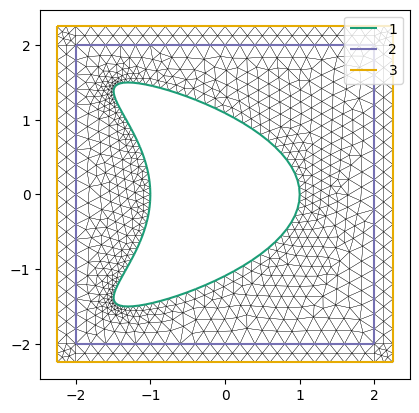

In [21]:
plot_mesh(mesh)

In [22]:
omega = 250
k = omega / c
u = exact_solution(mesh, k, x0)
uh = solve(mesh, k, a0, a1, b0, b1, u)

Exact solution:


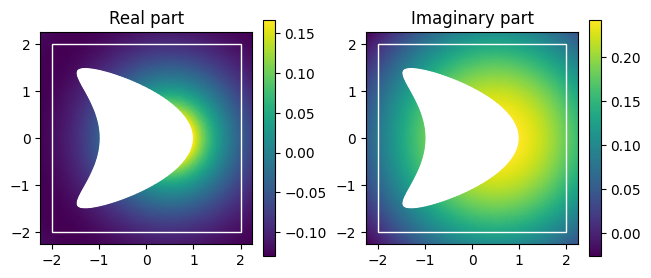

In [23]:
print("Exact solution:")
W = fd.VectorFunctionSpace(mesh, "CG", 1)
plot_field(fd.interpolate(u, W), a0, a1, b0, b1)

Numerical solution:


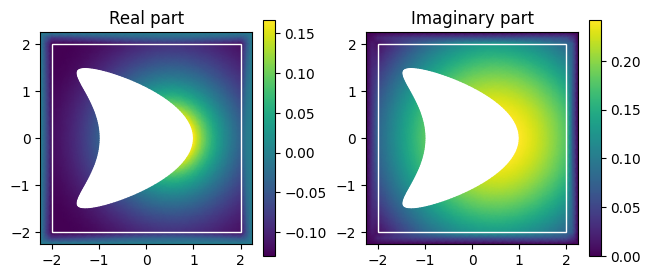

In [24]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

In [25]:
rel_err = compute_error(u, uh, quad_deg=4)
print(f"Relative error {rel_err:.2%}")

Relative error 1.36%


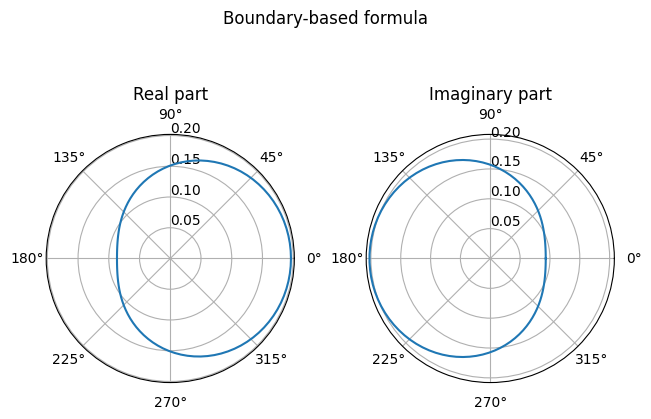

In [26]:
plot_far_field(k, uh)

In [27]:
# Convergence
max_level = 4
levels = np.arange(max_level)
hs = h0 / 2**levels
omegas = [250, 750, 1250, 1750]

In [28]:
# Uniform refinement
mesh_hierarchy = fd.MeshHierarchy(mesh, max_level)

angular freqency = 250
refinement level 0, relative error 1.36%
refinement level 1, relative error 0.29%
refinement level 2, relative error 0.08%
refinement level 3, relative error 0.02%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 1.87%
refinement level 1, relative error 0.58%
refinement level 2, relative error 0.17%
refinement level 3, relative error 0.06%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.76%
refinement level 1, relative error 1.02%
refinement level 2, relative error 0.29%
refinement level 3, relative error 0.08%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 8.43%
refinement level 1, relative error 2.25%
refinement level 2, relative error 0.59%
refinement level 3, relative error 0.15%
----------------------------------------


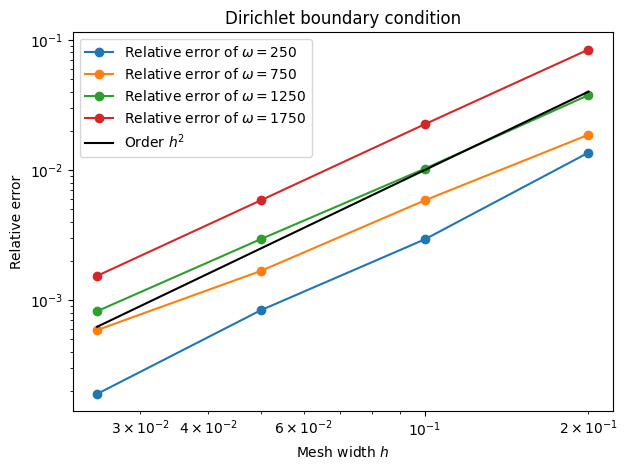

In [29]:
# Dirichlet problem
# L2 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.41%
refinement level 1, relative error 0.49%
refinement level 2, relative error 0.10%
refinement level 3, relative error 0.03%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.78%
refinement level 1, relative error 0.94%
refinement level 2, relative error 0.27%
refinement level 3, relative error 0.07%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.79%
refinement level 1, relative error 1.08%
refinement level 2, relative error 0.32%
refinement level 3, relative error 0.09%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 8.21%
refinement level 1, relative error 2.15%
refinement level 2, relative error 0.56%
refinement level 3, relative error 0.15%
----------------------------------------


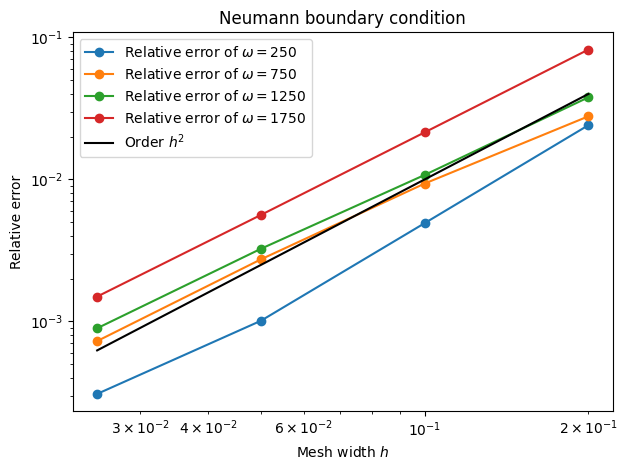

In [30]:
# Neumann problem
# L2 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

In [31]:
# Refinement by gmsh
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, h0, level))

angular freqency = 250
refinement level 0, relative error 1.36%
refinement level 1, relative error 0.74%
refinement level 2, relative error 0.53%
refinement level 3, relative error 0.18%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 1.87%
refinement level 1, relative error 0.82%
refinement level 2, relative error 0.45%
refinement level 3, relative error 0.35%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.76%
refinement level 1, relative error 1.18%
refinement level 2, relative error 0.45%
refinement level 3, relative error 0.20%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 8.43%
refinement level 1, relative error 2.39%
refinement level 2, relative error 0.68%
refinement level 3, relative error 0.22%
----------------------------------------


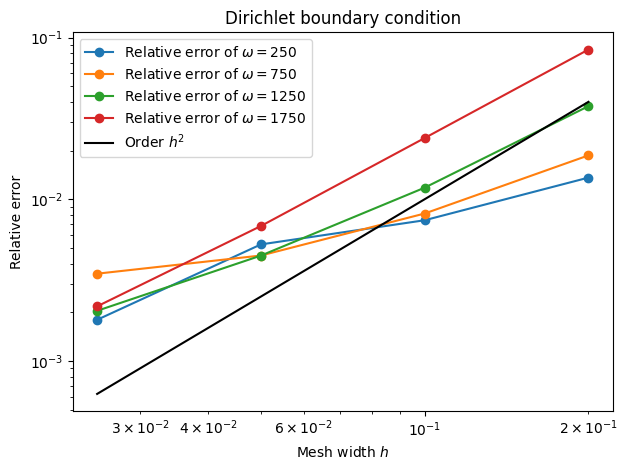

In [32]:
# Dirichlet problem
# L2 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.41%
refinement level 1, relative error 1.14%
refinement level 2, relative error 0.61%
refinement level 3, relative error 0.23%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.78%
refinement level 1, relative error 1.09%
refinement level 2, relative error 0.53%
refinement level 3, relative error 0.42%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 3.79%
refinement level 1, relative error 1.27%
refinement level 2, relative error 0.48%
refinement level 3, relative error 0.23%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 8.21%
refinement level 1, relative error 2.22%
refinement level 2, relative error 0.66%
refinement level 3, relative error 0.22%
----------------------------------------


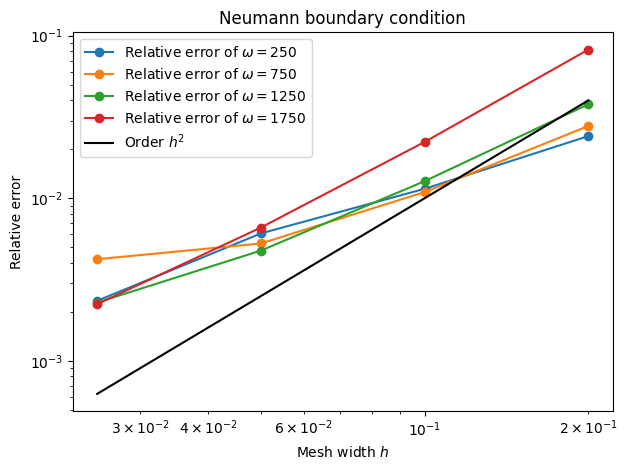

In [33]:
# Neumann problem
# L2 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 3.63%
refinement level 1, relative error 2.28%
refinement level 2, relative error 1.23%
refinement level 3, relative error 0.59%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 8.81%
refinement level 1, relative error 4.36%
refinement level 2, relative error 2.21%
refinement level 3, relative error 1.17%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 14.80%
refinement level 1, relative error 7.26%
refinement level 2, relative error 3.64%
refinement level 3, relative error 1.82%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 21.48%
refinement level 1, relative error 10.32%
refinement level 2, relative error 5.12%
refinement level 3, relative error 2.56%
----------------------------------------


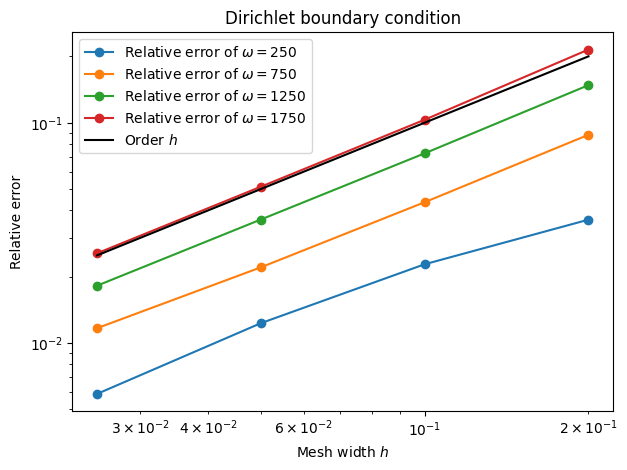

In [34]:
# Dirichlet problem
# H1 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 3.86%
refinement level 1, relative error 2.40%
refinement level 2, relative error 1.27%
refinement level 3, relative error 0.60%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 9.02%
refinement level 1, relative error 4.40%
refinement level 2, relative error 2.22%
refinement level 3, relative error 1.19%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 14.82%
refinement level 1, relative error 7.28%
refinement level 2, relative error 3.64%
refinement level 3, relative error 1.82%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 21.61%
refinement level 1, relative error 10.31%
refinement level 2, relative error 5.13%
refinement level 3, relative error 2.56%
----------------------------------------


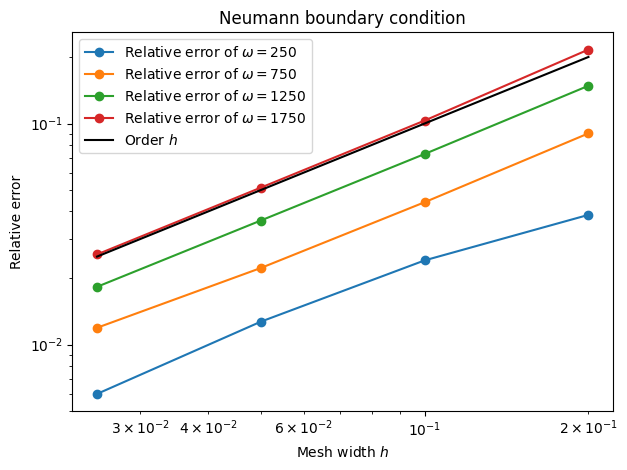

In [35]:
# Neumann problem
# H1 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

# Square

In [36]:
shape = "square"
a0 = b0 = 2.0
a1 = b1 = 2.25
cached_mesh = True

if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0)

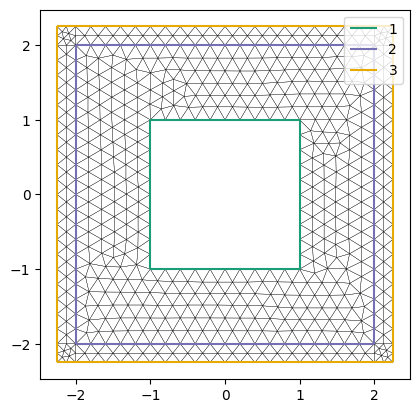

In [37]:
plot_mesh(mesh)

In [38]:
omega = 250
k = omega / c
u = exact_solution(mesh, k, x0)
uh = solve(mesh, k, a0, a1, b0, b1, u)

Exact solution:


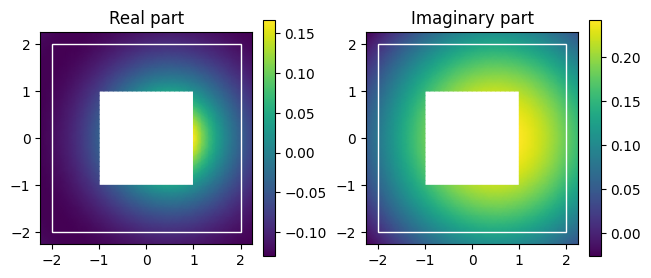

In [39]:
print("Exact solution:")
W = fd.VectorFunctionSpace(mesh, "CG", 1)
plot_field(fd.interpolate(u, W), a0, a1, b0, b1)

Numerical solution:


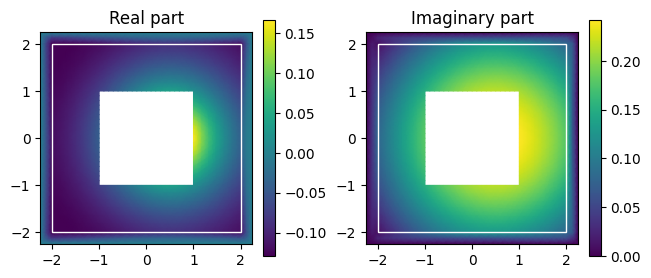

In [40]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

In [41]:
rel_err = compute_error(u, uh, quad_deg=4)
print(f"Relative error {rel_err:.2%}")

Relative error 1.15%


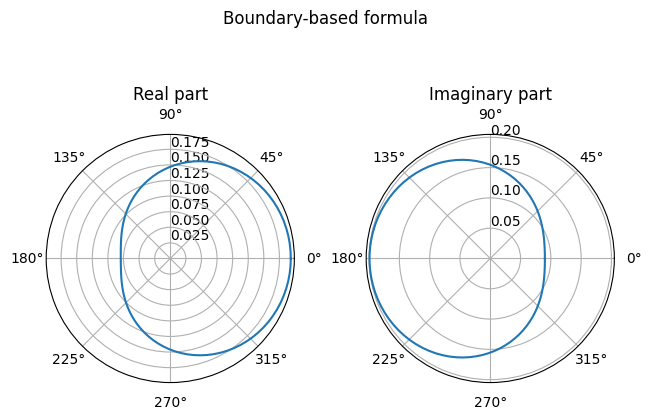

In [42]:
plot_far_field(k, uh)

In [43]:
# Convergence
max_level = 4
levels = np.arange(max_level)
hs = h0 / 2**levels
omegas = [250, 750, 1250, 1750]

In [44]:
# Uniform refinement
mesh_hierarchy = fd.MeshHierarchy(mesh, max_level)

angular freqency = 250
refinement level 0, relative error 1.15%
refinement level 1, relative error 0.26%
refinement level 2, relative error 0.08%
refinement level 3, relative error 0.02%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.11%
refinement level 1, relative error 0.66%
refinement level 2, relative error 0.19%
refinement level 3, relative error 0.06%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 5.44%
refinement level 1, relative error 1.46%
refinement level 2, relative error 0.39%
refinement level 3, relative error 0.10%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 11.20%
refinement level 1, relative error 3.04%
refinement level 2, relative error 0.78%
refinement level 3, relative error 0.20%
----------------------------------------


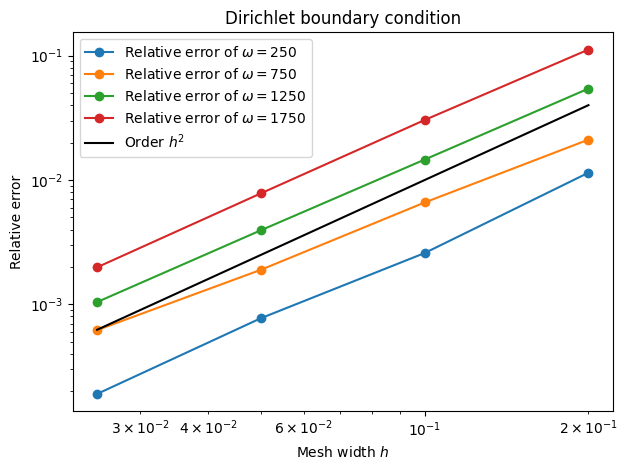

In [45]:
# Dirichlet problem
# L2 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.33%
refinement level 1, relative error 0.48%
refinement level 2, relative error 0.10%
refinement level 3, relative error 0.03%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.70%
refinement level 1, relative error 0.89%
refinement level 2, relative error 0.26%
refinement level 3, relative error 0.07%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 5.38%
refinement level 1, relative error 1.47%
refinement level 2, relative error 0.41%
refinement level 3, relative error 0.11%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 12.25%
refinement level 1, relative error 3.31%
refinement level 2, relative error 0.86%
refinement level 3, relative error 0.22%
----------------------------------------


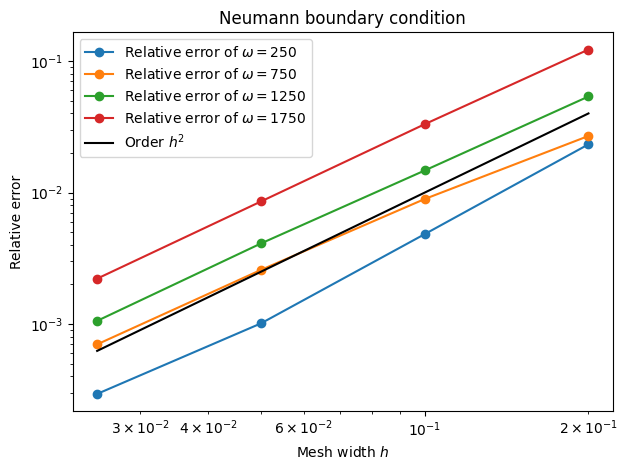

In [46]:
# Neumann problem
# L2 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

In [47]:
# Refinement by gmsh
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, h0, level))

angular freqency = 250
refinement level 0, relative error 1.15%
refinement level 1, relative error 0.83%
refinement level 2, relative error 0.49%
refinement level 3, relative error 0.18%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.11%
refinement level 1, relative error 0.90%
refinement level 2, relative error 0.48%
refinement level 3, relative error 0.35%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 5.44%
refinement level 1, relative error 1.59%
refinement level 2, relative error 0.55%
refinement level 3, relative error 0.23%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 11.20%
refinement level 1, relative error 3.10%
refinement level 2, relative error 0.83%
refinement level 3, relative error 0.25%
----------------------------------------


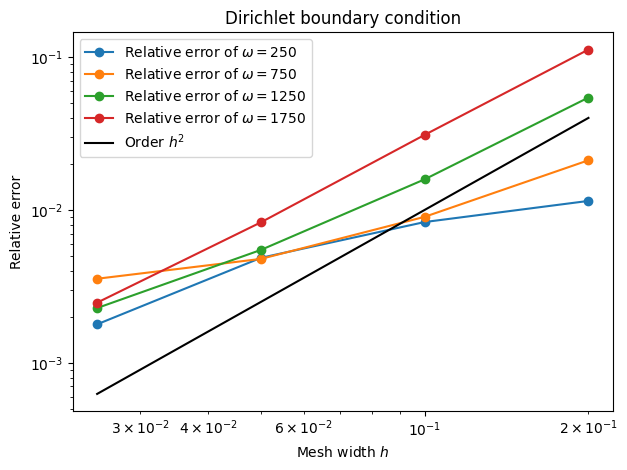

In [48]:
# Dirichlet problem
# L2 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 2.33%
refinement level 1, relative error 1.06%
refinement level 2, relative error 0.60%
refinement level 3, relative error 0.23%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 2.70%
refinement level 1, relative error 1.01%
refinement level 2, relative error 0.53%
refinement level 3, relative error 0.43%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 5.38%
refinement level 1, relative error 1.55%
refinement level 2, relative error 0.51%
refinement level 3, relative error 0.23%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 12.25%
refinement level 1, relative error 3.59%
refinement level 2, relative error 0.99%
refinement level 3, relative error 0.29%
----------------------------------------


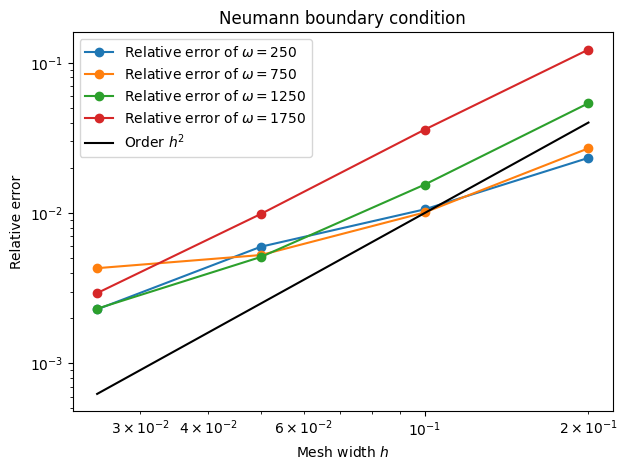

In [49]:
# Neumann problem
# L2 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 4.26%
refinement level 1, relative error 2.67%
refinement level 2, relative error 1.37%
refinement level 3, relative error 0.66%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 10.64%
refinement level 1, relative error 5.33%
refinement level 2, relative error 2.74%
refinement level 3, relative error 1.42%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 18.09%
refinement level 1, relative error 8.96%
refinement level 2, relative error 4.56%
refinement level 3, relative error 2.27%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 26.24%
refinement level 1, relative error 12.72%
refinement level 2, relative error 6.43%
refinement level 3, relative error 3.19%
----------------------------------------


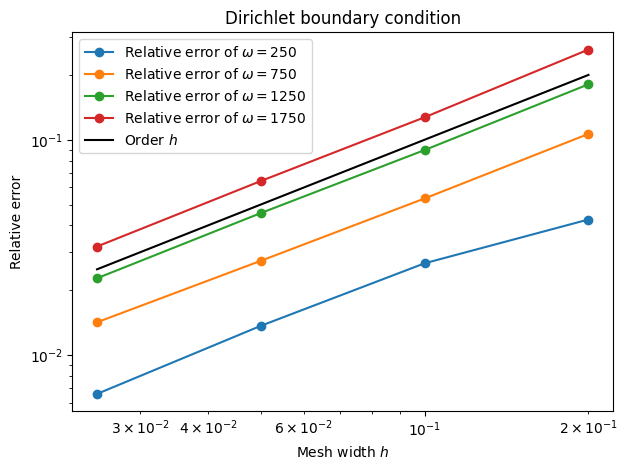

In [50]:
# Dirichlet problem
# H1 norm
neumann = False
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        u = exact_solution(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, u, neumann)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 4.45%
refinement level 1, relative error 2.72%
refinement level 2, relative error 1.41%
refinement level 3, relative error 0.67%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 10.76%
refinement level 1, relative error 5.35%
refinement level 2, relative error 2.75%
refinement level 3, relative error 1.44%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 18.18%
refinement level 1, relative error 8.96%
refinement level 2, relative error 4.56%
refinement level 3, relative error 2.27%
----------------------------------------
angular freqency = 1750
refinement level 0, relative error 26.89%
refinement level 1, relative error 12.86%
refinement level 2, relative error 6.45%
refinement level 3, relative error 3.19%
----------------------------------------


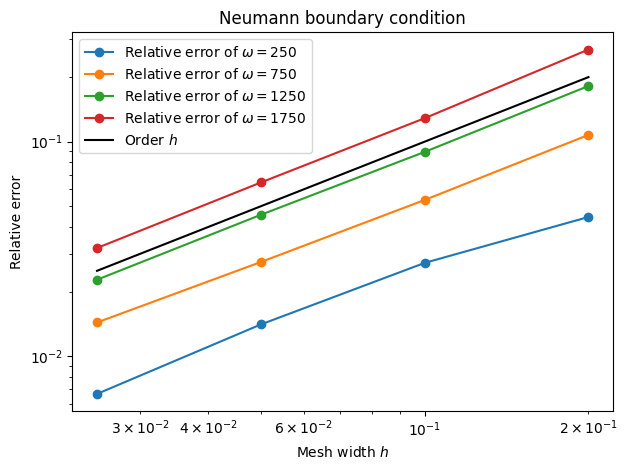

In [51]:
# Neumann problem
# H1 norm
neumann = True
for omega in omegas:
    print(f"angular freqency = {omega}")
    k = omega / c
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        g = neumann_bc(m, k, x0)
        uh = solve(m, k, a0, a1, b0, b1, g, neumann, quad_deg=5)
        u = exact_solution(m, k, x0)
        rel_err = compute_error(u, uh, norm="h1", quad_deg=4)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()